In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv("../data/processed/train.csv")
val = pd.read_csv("../data/processed/val.csv")
test = pd.read_csv("../data/processed/test.csv")

train.head()

,date,store,item,sales,time_idx,day_of_week,week_of_year,month,is_weekend,lag_1,lag_7,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,is_holiday
0,2013-01-31,4,6,32,30,3,5,1,0,27.0,30.0,34.0,33.000000,4.654747,33.600000,7.779726,0
1,2013-01-31,10,41,19,30,3,5,1,0,10.0,8.0,17.0,13.428571,3.909695,12.800000,3.089470,0
2,2013-01-31,5,35,32,30,3,5,1,0,28.0,23.0,23.0,27.714286,5.407226,29.333333,6.748350,0
3,2013-01-31,7,46,20,30,3,5,1,0,18.0,22.0,26.0,21.714286,5.437962,22.700000,6.406624,0
4,2013-01-31,9,18,55,30,3,5,1,0,47.0,46.0,52.0,52.285714,10.355583,50.733333,11.212473,0


In [3]:
val["naive_pred"] = val["lag_1"]

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}


In [5]:
naive_metrics = evaluate(val["sales"], val["naive_pred"])
naive_metrics


{'RMSE': np.float64(14.701657635323896),
 'MAE': 10.735744525547446,
 'MAPE': np.float64(23.320713769069368)}

In [6]:
val["ma7_pred"] = val["rolling_mean_7"]


In [7]:
ma7_metrics = evaluate(val["sales"], val["ma7_pred"])
ma7_metrics


{'RMSE': np.float64(11.341089020189427),
 'MAE': 8.580595411887382,
 'MAPE': np.float64(18.27168886381531)}

In [8]:
val["seasonal_pred"] = val["lag_7"]


In [9]:
seasonal_metrics = evaluate(val["sales"], val["seasonal_pred"])
seasonal_metrics


{'RMSE': np.float64(11.286324972587902),
 'MAE': 8.590956204379562,
 'MAPE': np.float64(18.845790113387263)}

In [10]:
baseline_results = pd.DataFrame({
    "Naive": naive_metrics,
    "MA(7)": ma7_metrics,
    "Seasonal Naive": seasonal_metrics,
}).T

baseline_results


,RMSE,MAE,MAPE
Naive,14.701658,10.735745,23.320714
MA(7),11.341089,8.580595,18.271689
Seasonal Naive,11.286325,8.590956,18.845790


In [29]:
import matplotlib.pyplot as plt

# Check types
print(val["store"].dtype, val["item"].dtype)

# If they are integers (most likely)
sample = val[(val["store"] == 1) & (val["item"] == 1)].sort_values("date")

print(sample.shape)   # make sure it's not (0, N)
sample.head()


int64 int64
(274, 20)


,date,store,item,sales,time_idx,day_of_week,week_of_year,month,is_weekend,lag_1,lag_7,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,is_holiday,naive_pred,ma7_pred,seasonal_pred
77,2016-07-02,1,1,32,1278,5,26,7,1,42.0,31.0,28.0,29.857143,6.039552,26.933333,5.582814,0,42.0,29.857143,31.0
792,2016-07-03,1,1,35,1279,6,26,7,1,32.0,32.0,35.0,30.000000,6.082763,27.166667,5.645159,0,32.0,30.000000,32.0
1126,2016-07-04,1,1,18,1280,0,27,7,0,35.0,26.0,23.0,30.428571,6.347103,27.066667,5.470506,1,35.0,30.428571,26.0
1642,2016-07-05,1,1,31,1281,1,27,7,0,18.0,28.0,22.0,29.285714,7.825477,26.733333,5.711050,0,18.0,29.285714,28.0
2089,2016-07-06,1,1,22,1282,2,27,7,0,31.0,25.0,22.0,29.714286,7.825477,26.600000,5.555985,0,31.0,29.714286,25.0


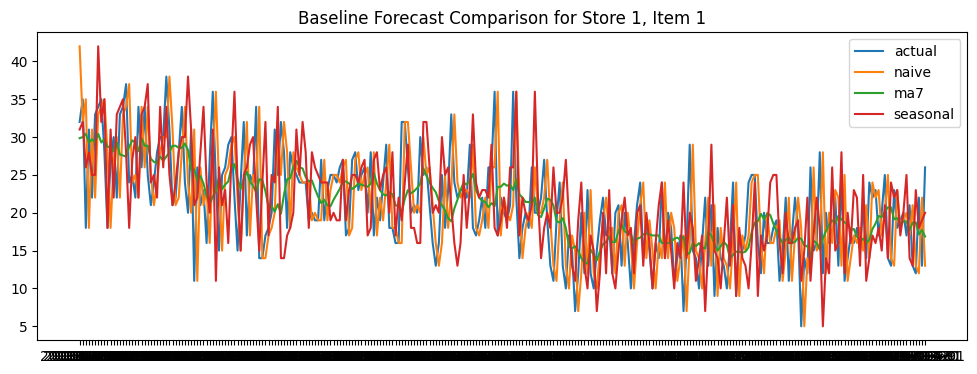

In [30]:
plt.figure(figsize=(12,4))
plt.plot(sample["date"], sample["sales"], label="actual")
plt.plot(sample["date"], sample["naive_pred"], label="naive")
plt.plot(sample["date"], sample["ma7_pred"], label="ma7")
plt.plot(sample["date"], sample["seasonal_pred"], label="seasonal")
plt.legend()
plt.title("Baseline Forecast Comparison for Store 1, Item 1")
plt.show()
